# Classification 

### Christian Holm Christensen

We want to classify new data based on train samples.  The idea is as follows 

- We have training samples which we _a priori_ know are either signal or background.  
- We then set-up criteria, based on these training samples, to classify data as either signal or background.  
- Then, given new data, we want to _a posteriori_ categorise the new data as either signal or background using the criteria developed above. 

There are tons of methods for doing this kind of analysis.  In recent years the idea of _machine learning_ has developed around this idea of classification.   Many of these techniques revolve around some kind of black-box algorithms, such as _neural networks_ or _boosted decision trees_.  

Here, however, we will first consider a much older but much more rigorous method called _Principal Component Analysis_. 

## Principal Component Analysis 

The idea of principal component analysis (PCA) is pretty straight forward.   Suppose we have a multi-variate data sample 

$$X=\left\{\left(x_1,\ldots,x_p\right)_i\,\middle|\,i=1,\ldots,N\right\}\quad,$$ 

centered around 0 and with unit standard deviation in each component $x_i$.  If this is not the case, then we can simply shift and scale our data set so that 

$$X'=\left\{\frac{x_1-\overline{x}_1}{s_1},\ldots,\frac{x_p-\overline{x}_p}{s_p}\,\middle|\,i=1,\ldots,N\right\}\quad,$$

where $\overline{x}_j,s_j$ are the mean and standard deviation, respectively, of the $j=1,\ldots,p$ component.  We then substitute $X'$ for $X$. 

We can calculate the covariance matrix of this data set by 

$$C = \frac{X^TX}{N-1}\quad,$$ 

which is an $p\times p$ symmetric matrix.  Because of this, we can decompose $C$ as 

$$C = V\Lambda V^{-1}\quad,$$ 

where $V$ is the matrix with of eigen-vectors (as columns) and $\Lambda$ is the diagonal matrix of eigen-values.  From linear algebra we know that the set of eigen-vectors form an orthonormal basis of the space spanned by $C$.  Thus, we also know from linear algebra that we can write any $X_i$ as a linear combination of the eigen-vectors $v_j$

$$x_i = \sum_{i=j}^{p}a_{ij} v_j\quad,$$ 

and $a_{ij}$ are coefficients.   Suppose we truncate this sum at some $k < p$, so that we have 

$$x_i = \sum_{j=1}^{k}a_{ij} v_j\quad k < p\quad,$$

then we want to minimize the error

$$\Delta_k = \frac{1}{N}\sum_{i=1}^{N} \left(x_i - x'_i\right)^2
 = \left\langle\left(x_i - \sum_{i=1}^{k} a_{ij}v_j\right)^2\right\rangle\quad,$$

where $\langle\cdot\rangle$ indicates the average of the $N$ samples. 

Multiplying the truncated expansion and using that the eigen-vectors are orthonormal ($v_i\cdot v_j=\delta_{ij}$), we find 

$$a_{ij} = x_i^T\cdot v_j\quad,$$

so that 

\begin{align*}
  \Delta_k 
  &= \left\langle\left(\sum_{j=k+1}^{p}a_{ij}v_j\right)^2\right\rangle\\
  &= \left\langle\left(\sum_{j=k+1}^{p}x_i^Tv_jv_j\right)^2\right\rangle\\
  &= \left\langle\sum_{j=k+1}^{p}v_j^Tx_ix_i^Tv_j\right\rangle\quad\text{because}\ v_i\cdot v_j=\delta_{ij}\\
  &= \sum_{j=k+1}^{p} e_j^T C e_j\quad,
\end{align*}

and the minimum is when each term in the sum is minimum (since $C$ is positive definite).  By method of Lagrange multipliers we get 

$$\Delta_k = \sum_{j=k+1}^{p} v_j^T C v_j - l_j v_j^T v_j + l_j),\quad$$

and the minimum condition 

$$\frac{d\Delta_k}{dv_j}=0\quad,$$

leads to 

$$Cv_j= l_jv_j$$ 

showing that $v_j$ are eigen-vectors of $C$ with eigen-values $l_j$. The estimate of the error is then 

$$\Delta_k \approx \sum_{j=k+1}^p l_j\quad,$$ 

where $l_{k+1},\ldots,l_{p}$ are the associated eigen-values of the eigen-vectors omitted in the above truncated expansion.  Thus, the error is small if we leave out the $p-k$ eigen-vectors corresponding to the least $p-k$ eigen-values. 

See also [a neat proof given on StackExchange](https://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit#answer-219344)

We want to set up the transformation from our sample space $\mathbb{X}$ into the space $\mathbb{P}$ spanned by the eigen-vectors $v_j$. This space, $\mathbb{P}$, is called the _principal_ vector space owing to the orthogonality of the eigen-vectors, and because the dimensions are ordered by the associated eigen-values.  The projection is simply given by 

$$q = Vx\quad,$$ 

and is called the _principal component_ of $x$.  Here, $V$ is the matrix of eigen-vectors (or _principal axes_) of $C$.   The inverse transformation is simply 

$$x = V^Tq\quad,$$ 

because $V$ is real and orthonormal.  

We can also form the inverse transform, but using only the $k$ most important principal axes 

$$x_k = V_k^Tq\quad,$$ 

where $V_k$ is the $k$ first columns of $V$, corresponding to the $k$ most important eigen-values (and -vectors). 

If $k=p$, then clearly 

$$x_p = V_p^Tq = V^Tq = V^TVx = x\quad.$$ 

However, if $k<p$, we make an error given by 

$$\delta_k = |x - x_k| = |x - V_k^Tq| = |x - V_k^TVx|\quad,$$

which we can evaluate for any $x$.  If this error is small, then $x$ belongs in the sub-space spanned by $C$.  Since $x$ is normalised to the standard deviation of sample $X$ a value larger than 1 signifies significant deviation. 

Let us implement a class to do the PCA, transforms, and testing for us.

In [1]:
class PCA:
    """Class to do a PCA"""
    def __init__(self,data,ddof=1):
        """Find eigen-vector and -values of covariance matrix of data"""
        from numpy import dot, sqrt
        from numpy import cov as xcov
        from numpy.linalg import eig, norm
    
        d      = self._center(data)     
        n, _   = d.shape
        cov    = dot(d.T, d) / (n-ddof)
        #cov   = xcov(d, rowvar=False)
        l, v   = eig(cov)
        idx    = l.argsort()[::-1]
        self.l = l[idx] / norm(l)
        self.v = v[:,idx] 
    
    def _center(self,data):
        """Center and scale data if not done already"""
        from numpy import allclose,zeros,ones 
        
        n, m   = data.shape
        if n < 1:
            raise ValueError('Input data is singular')
        if m is None or m < 2: 
            raise ValueError('Input data is one-dimensional')
            
        d      = data
        self.m = d.mean(axis=0)
        self.s = d.std(axis=0)
        
        if not allclose(self.m,zeros(m)):
            d = d.copy() - self.m
            
        if not allclose(self.s,ones(m)):
            if d is data: d = d.copy()
            d /= self.s
            
        return d
            
    def to_pc(self,data):
        """Transform to principal space"""
        return ((data-self.m)/self.s).dot(self.v)

    def from_pc(self,pca,k=None):
        """Transform to sample space"""
        from numpy import atleast_2d

        if k is None: k = len(self.m)
        
        pp = atleast_2d(pca)
        return self.m + pp[:,:k].dot(self.v.T[:k,:])*self.s

    def test(self,data,k):
        """Evaluate distance to the k-subspace of the prinicple space"""
        from numpy import abs,sqrt
        xx = self.from_pc(self.to_pc(data),k)
        r2 = ((data-xx)/self.s)**2
        return sqrt(r2.sum(axis=1))/k

    def __str__(self):
        """Pretty print an object of this class"""
        return f'{"mean":10} {"std":10}  {"lambda":10} {"V"}\n'+\
            '\n'.join([f"{m:10g} {s:10g}  {l:10g} " 
                       + ' '.join([f"{v:10g}" for v in vc])
                       for m,s,l,vc in zip(self.m,self.s,self.l,self.v)])

### Test of class 
Let us test this class on some training data. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt 

train1_bg = np.genfromtxt('BDT_background_train.txt')
train1_sg = np.genfromtxt('BDT_signal_train.txt')

First, we plot the two data samples, just to see what is going on.

In [3]:
def hist2d(x,y,*args,**kwargs):
    from numpy import histogram2d,meshgrid
    from matplotlib.pyplot import gca 
    ax = kwargs.pop('ax',gca())
    sc = kwargs.pop('scale',1)
    
    h,bx,by = histogram2d(x,y,*args,density=True)
    xx, yy  = meshgrid((bx[1:]+bx[:-1])/2,(by[1:]+by[:-1])/2)
    ax.scatter(xx.ravel(),yy.ravel(),h.ravel()*len(x)*sc,**kwargs)

In [4]:
def drawsamples(*args,**kwargs):
    from numpy import tril_indices, triu_indices, ndarray
    from matplotlib.pyplot import subplots,subplot2grid
    from matplotlib.lines import Line2D
    
    if len(args) < 1:
        raise ValueError('No data given')
    
    d1 = args[0]
    try:
        _, n = d1.shape
    except:
        raise ValueError('1st argument not data')
    
    title = kwargs.pop('title','')
    leg   = kwargs.pop('legend',False)
    names = kwargs.pop('names', None)
    figkw = kwargs.pop('fig_kw',{})
    
    if isinstance(names,list) and len(names) < n:
        raise ValueError(f'Not enough {len(names)} '
                         'names given, need {n}')
    elif isinstance(names,bool) and names:
        if n < 4:
            off = ord('x')
        else: 
            off = ord('a')
        names = [fr'${chr(i+off)}$' for i in range(n)]
        
    fig, ax = plt.subplots(ncols=n,nrows=n,
                           sharex='col',sharey='row',
                           gridspec_kw=dict(hspace=0,wspace=0),
                           **figkw)
    fig.suptitle(title)
    
    dax = [None]*n
    for i, j in zip(*triu_indices(n)):
        if i == j: 
            dax[i]  = ax[i,j].twinx()
            ax[i,j].yaxis.set_visible(False)
        else:
            ax[i,j].remove()#.axis('off')
        
    def _one(v,ax,dax,n,names,**kwargs):
        hist_kw = kwargs.pop('hist_kw',{})
        scat_kw = kwargs.pop('scat_kw',{})
        hist_oth= {k:kwargs[k] for k in kwargs if not hasattr(hist_kw,k)}
        scat_oth= {k:kwargs[k] for k in kwargs if not hasattr(scat_kw,k)}
        for i, j in zip(*tril_indices(n)):
            a  = dax[i] if i == j else ax[i,j]
            a.grid()
            if names is not None:
                if i == n-1:
                    ax[i,j].set_xlabel(names[j])
                if j == 0 and i != 0:
                    ax[i,j].set_ylabel(names[i]) 
                    
            if i == j:
                ar = a.hist(v[i],20,histtype='step',density=True,
                            **hist_kw,**hist_oth)
            else:
                scale = scat_kw.pop('scale',1)/n 
                alpha = scat_kw.pop('alpha',scat_oth.pop('alpha',.5))
                hist2d(v[j],v[i],20,ax=a,alpha=alpha,scale=scale,
                       **scat_kw,**scat_oth)
                
        if kwargs.get('label',False):
            return ar[-1][0]
        
    
    skip = 0
    cur  = 0
    ll   = []
    for o, d in enumerate(args):
        if skip > 0:
            skip -= 1
            continue
            
        try:
            _, m = d.shape 
        except:
            raise ValueError('Argument is not data')
        
        if n != m:
            raise ValueError(f'Data set {cur+1} of {m} variables not '
                             f'consistent with data set 1 of {n} variables')
    
        lbl=None
        kw=kwargs.copy()
        for oo in (o+1,o+2):
            if oo < len(args):
                if isinstance(args[oo],str):
                    kw['label'] = args[oo]
                    skip += 1
                elif isinstance(args[oo],dict):
                    kw = args[oo]
                    skip += 1
                    
        if kw.get('color','') == 'auto':
            kw['color'] = 'C'+str(cur)
            
        l = _one(d.T,ax,dax,n,names,**kw)
        if l is not None:
            ll.append(l)
        cur += 1    
        
    if leg:
        o = (n+1)//2
        s = n//2
        lax = subplot2grid((n,n),(0,o),rowspan=s,colspan=s)
        lax.axis('off')
        lax.legend(ll,[l.get_label() for l in ll])

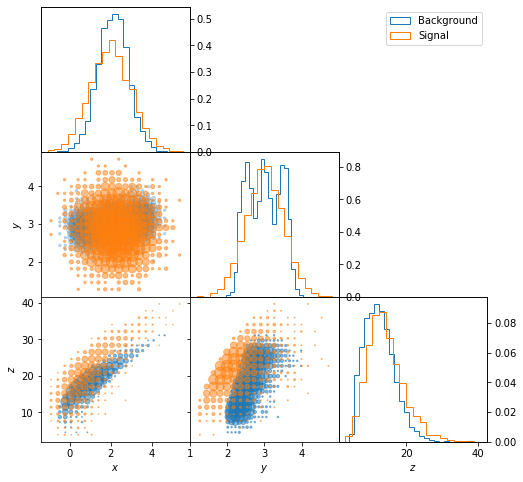

In [46]:
drawsamples(train1_bg, 'Background', train1_sg, 'Signal', 
            legend=True,names=True,fig_kw=dict(figsize=(8,8)),
            scat_kw=dict(scale=.5,alpha=.25),color='auto')

We make a PCA object for each of the sample 

In [6]:
pca1_bg = PCA(train1_bg)
pca1_sg = PCA(train1_sg)
print('* Background:\n',pca1_bg)
print('* Signal:\n',    pca1_sg)

* Background:
 mean       std         lambda     V
   2.10558   0.742904    0.955962  -0.571909  -0.595093   -0.56461
   3.00259   0.437428    0.293366  -0.491215   0.799678  -0.345287
   12.3319    4.20292  0.00853279  -0.656984  -0.079873   0.749661
* Signal:
 mean       std         lambda     V
   1.97833   0.996624    0.880883   0.570755   0.589649   0.571449
    3.0046   0.504563    0.473012   0.406332  -0.807574   0.427456
   14.1892    5.11111   0.0174438   0.713536 -0.0117748   -0.70052


Before going any further, we test a few features of the `PCA` class.  First, we transform our training sample to $\mathbb{P}$ space and the back again to the $\mathbb{X}$ space.  We then assert that the round-robin transform is the identity. 

In [7]:
pp = pca1_bg.to_pc(train1_bg)
dd = pca1_bg.from_pc(pp)
assert np.allclose(dd,train1_bg)

Since our data set is 3-dimensional we can just bare illustrate this.  We plot the original data points, as well as the data points transformed back to the sample space $\mathbb{X}$ using only the 2 most significant eigen-vectors.  We illustrate the plane spanned by these two eigen vectors and draw all three eigen-vectors too. 

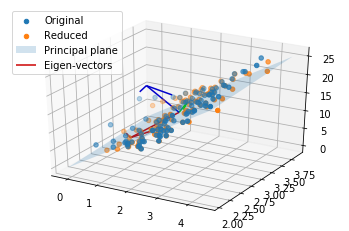

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xx  = train1_bg[:100,...]
ax.scatter(*xx.T,label='Original')

pp  = pca1_bg.to_pc(xx)
yy  = pca1_bg.from_pc(pp,2)
ax.scatter(*yy.T,label='Reduced')

vv     = pca1_bg.v * pca1_bg.s
nn     = np.cross(vv[0],vv[1])
dd     = -(pca1_bg.m).dot(nn)
mx, my = np.meshgrid(ax.get_xlim(),ax.get_ylim())
mz     = (-nn[0] * mx - nn[1] * my - dd) * 1. /nn[2]
sf = ax.plot_surface(mx,my,mz,alpha=.2,label='Principal plane')
setattr(sf,'_edgecolors2d',np.empty((0,4)))
setattr(sf,'_facecolors2d',np.empty((0,4)))

ax.quiver3D(*pca1_bg.m,*vv.T,length=2,
            colors=((.8,0,0),(0,.8,0),(0,0,.8),
                    (.8,0,0),(.8,0,0),
                    (0,.8,0),(0,.8,0),
                    (0,0,.8),(0,0,.8)),
            label='Eigen-vectors')

ax.legend();

### Analysis of 3 variables 
#### Training sample 
From the printout above, we see that the first two eigen-values of the background training sample are significantly larger than the third.  Let us therefor test how big an error we would do if we only used the first to principal axes.  

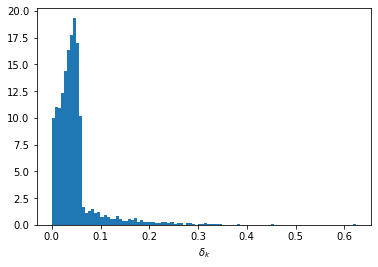

In [9]:
bgbge1 = pca1_bg.test(train1_bg,2)
plt.hist(bgbge1,100,density=True);
plt.xlabel(r'$\delta_k$');

We see that most of our data falls below 0.07 or so. 

Let us try the background PCA on the signal sample and plot the error from using only two principal axes.  We plot the distribution together with the distribution from the background training sample for comparison. 

In [10]:
def drawerr(bg,sg,cut=None,title='',bins=100,**kwargs):
    from matplotlib.pyplot import gca 
    
    ax = kwargs.pop('ax',gca())
    
    ax.hist(bg,bins,density=True,color='C0',alpha=.3,label='Background');
    ax.hist(sg,bins,density=True,color='C1',alpha=.3,label='Signal');
    ax.hist(bg,bins,density=True,color='C0',histtype='step');
    ax.hist(sg,bins,density=True,color='C1',histtype='step');
    
    if cut is not None:
        ax.axvline(cut,ls='--',color='C2',label=fr'Cut {cut:4g}')
        
    ax.set_title(title)
    ax.set_xlabel(r'$\delta_k/k$')
    ax.legend()

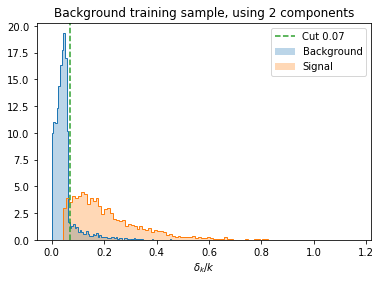

In [11]:
sgbge1 = pca1_bg.test(train1_sg,2)
bgcut1 = 0.07
drawerr(bgbge1,sgbge1,bgcut1,'Background training sample, using 2 components')

Clearly, the signal sample has a much larger error than the background sample.  In fact, with a cut of 0.22, we would get 

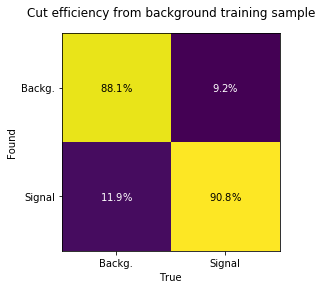

In [12]:
def cuteff(same,other,cut,norm=True):
    from numpy import array, float
    e = array([[sum(same<cut),  sum(other< cut)],
               [sum(same>=cut), sum(other>=cut)]],
               dtype=float)
    if norm:
        e[:,0] /= len(same)
        e[:,1] /= len(other)
    return e

def draweff(e,title,**kwargs):
    from numpy import ndenumerate
    from matplotlib.pyplot import gca,colorbar 
    ax = kwargs.pop('ax',gca())
    cb = kwargs.pop('cb',False)
    vl = kwargs.pop('vl',True)
    
    a = ax.matshow(e,**kwargs)
    
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Backg.','Signal'])
    ax.set_yticklabels(['Backg.','Signal'])
    ax.tick_params(axis="x",bottom=True,top=False,labelbottom=True,labeltop=False)
    ax.set_xlabel('True')
    ax.set_ylabel('Found')
    ax.set_title(title)
    
    if vl: 
        aa = (e.max()-e.min())/2
        for (j,i),v in ndenumerate(e):
            c = 'k' if v > aa else 'w'
            ax.text(i,j,fr'${v*100:.1f}\%$',
                    color=c,ha='center',va='center')
    
    #if cb: colorbar(a,ax=ax)
        
    return a

ebg1 = cuteff(bgbge1,sgbge1,bgcut1)
draweff(ebg1,'Cut efficiency from background training sample',cb=True);

Thus, we have a $90\%$ success rate at identifying signals and an $88\%$ success rate for background. With this selection we would have roughly $11\%$ background contamination in our signal selection. 

But we can do better.  We also have a training sample for the signal events.  We can apply the same methodology as we did for the background training sample 

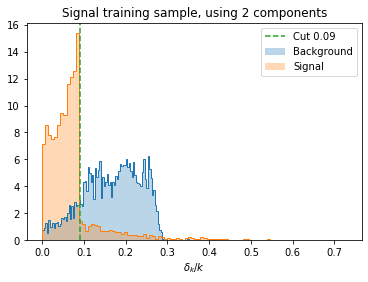

In [13]:
bgsge1 = pca1_sg.test(train1_bg,2)
sgsge1 = pca1_sg.test(train1_sg,2)
sgcut1 = 0.09
drawerr(bgsge1,sgsge1,sgcut1,'Signal training sample, using 2 components');

Here, a cut of $0.09$ seem more appropriate.  Let us again calculate the efficiency of the signal cut

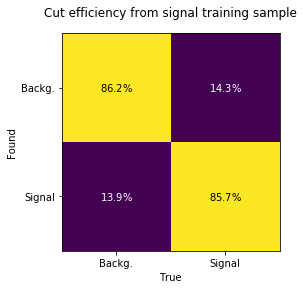

In [14]:
esg1 = cuteff(sgsge1,bgsge1,sgcut1)
draweff(esg1,'Cut efficiency from signal training sample',cb=True)

The signal cut does not help in categorising the events.  What we can do, though, is to _combine_ the two PCAs. 

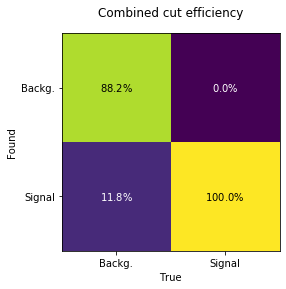

In [15]:
def dualcuteff(bb,sb,bcut,
              ss,bs,scut,norm=True):
    from numpy import array, float
    e = array([[sum(bb/bcut< bs/scut), sum(ss/scut>=sb/bcut)],
               [sum(bb/bcut>=bs/scut), sum(ss/scut< sb/bcut)]],
               dtype=float)
    if norm:
        e[:,0] /= len(bb)
        e[:,1] /= len(ss)
    return e

edual1 = dualcuteff(bgbge1,sgbge1,bgcut1,sgsge1,bgsge1,sgcut1,norm=True)
draweff(edual1,'Combined cut efficiency',cb=True);

Thus, we now correctly identify _almost all_ signal events, but with a smaller contamination of $11\%$ background events of our signal sample. 

#### Test sample

We have two more data set we can test this on.  Let us load them and draw them as before 

In [16]:
test1_bg = np.genfromtxt('BDT_background_test.txt')
test1_sg = np.genfromtxt('BDT_signal_test.txt')

In [17]:
bgbge1t = pca1_bg.test(test1_bg,2)
sgbge1t = pca1_bg.test(test1_sg,2)
bgsge1t = pca1_sg.test(test1_bg,2)
sgsge1t = pca1_sg.test(test1_sg,2)

fig, ax = plt.subplots(ncols=2)
drawerr(bgbge1t,sgbge1t,bgcut1,title=r'Background error $k=2$',ax=ax[0])
drawerr(bgsge1t,sgsge1t,sgcut1,title=r'Signal error $k=2$',ax=ax[1])

plt.tight_layout()

Again, we calculate the efficiencies 

In [18]:
edual1t = dualcuteff(bgbge1t,sgbge1t,bgcut1,sgsge1t,bgsge1t,sgcut1)
draweff(edual1t,'Combined cut efficiency',cb=True)

We get similar results to what we saw on the training samples - all signal events are correctly identified with a small contamination of $11\%$ background hits. 

One of the benefits of using a method such as PCA, is that it is entirely reversible.   All we do, is to do a linear transformation of our data, which we can easily revert - there are no fudge parameters that will mess with our uncertainties, and we know quite well what our uncertainties are. 

### Analysis of 16 variables

Next, we read in another data set.

In [19]:
data2    = np.genfromtxt('BDT_16var.txt')[:,1:]

This data set consist of 16 variables, and the data is formatted such that every second is signal while the other half is background. 

In [20]:
bg2 = data2[1::2,:]
sg2 = data2[::2,:]

We need to make 2 sets - a training and test sample - of each of the background and signal samples. Typically, training samples are obtained from simulations of which we often much smaller samples than we have for the data to analyse.   We therefor select 1/3 - at random - of each of the background and signal samples as the training samples.  

In [21]:
n         = len(bg2)
off       = n//3
idx       = np.random.choice(np.arange(n),replace=False,size=n)
train2_bg = bg2[idx[:off],:]
test2_bg  = bg2[idx[off:],:]
train2_sg = sg2[idx[:off],:]
test2_sg  = sg2[idx[off:],:]

Below we plot 6 of the 16 variables - just to get an idea of the data.  The plot of all 16 variables is practically not readable. 

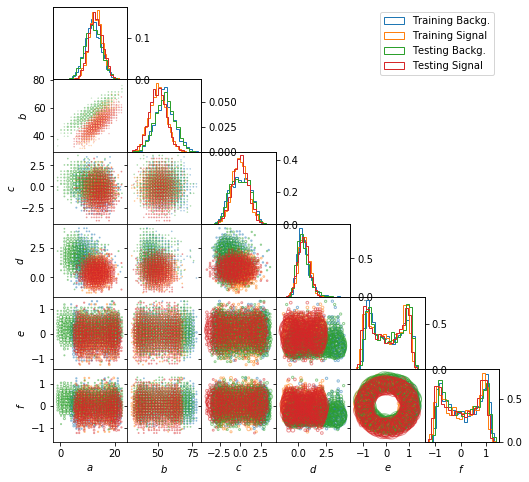

In [22]:
nd2 = 6
drawsamples(train2_bg[:,:nd2], 'Training Backg.', 
            train2_sg[:,:nd2], 'Training Signal', 
            test2_bg[:,:nd2],  'Testing Backg.',  
            test2_sg[:,:nd2],  'Testing Signal',
            legend=True,names=True,fig_kw=dict(figsize=(8,8)),
            scat_kw=dict(scale=.001,alpha=.1,facecolor='none'),
            color='auto')

#### A function to do the PCA

We will essentially do what we did above for 3 variables, and we will do that for training and testing sample.  Let us encode this into a function to make life easier.  In the function, we do 

- Train to PCA objects - one for the background sample and one for the signal sample - just as above, if not given. 
- We plot the eigen-values of each to get an idea of what is going on if so requested or we made the PCA objects 
- Thus, we calculate the error of each element of the training samples with respect to it self and the other training sample, so as to access the needed cuts. 
- Given the cuts for the background and signal training samples, we can estimate the cut efficiencies - separately for background and signal, as well as the for the dual cut. 

In [23]:
def run_pca(bg, sg, ignore=0, bgcut=None, sgcut=None, 
            title='', pca_bg=None, pca_sg=None,
            bins=30,showl=False,showe=True,norme=True):
    from numpy import flip 
    from matplotlib.pyplot import figure, plot, subplot2grid,tight_layout
    
    n, p  = bg.shape
    k     = p-ignore
    
    if pca_bg is None and pca_sg is None: 
        pca_bg = PCA(bg)
        pca_sg = PCA(sg)
        showl  = True 
        
    if bgcut is None or sgcut is None:
        showe = False
    
    bgbge = pca_bg.test(bg,k)
    sgbge = pca_bg.test(sg,k)
    bgsge = pca_sg.test(bg,k)
    sgsge = pca_sg.test(sg,k)
    
    nc  = 6
    nr  = 2
    if showl: nr += 1
    if showe: nr += 1
     
    rc  = (nr,nc)
    sr  = 1  if showl else 0
    fig = figure(figsize=(10,2*nr))
    fig.suptitle(title)
    
    if showl:
        ax = subplot2grid(rc,(0,0),colspan=nc)
        ax.plot(pca_bg.l,drawstyle='steps-mid',label='Background')
        ax.plot(pca_sg.l,drawstyle='steps-mid',label='Signal')
        ax.axvline(k-.5, ls='--',label=fr'$k={k}$',color='C2')    
        ax.set_xlabel(r'$j$')
        ax.set_ylabel(r'$\lambda_j$')
        ax.legend()
        ax.set_title('Eigen-values')
        
    
    axbge = subplot2grid(rc,(sr, 0),    colspan=nc//2,rowspan=2)
    axsge = subplot2grid(rc,(sr, nc//2),colspan=nc//2,rowspan=2)
    drawerr(bgbge,sgbge,bgcut,bins=bins,
            title='Distance to background',ax=axbge)
    drawerr(bgsge,sgsge,sgcut,bins=bins,
            title='Distance to signal',ax=axsge)
    
    edual = None
    if showe:
        axbgc = subplot2grid(rc,(sr+2,0),      colspan=nc//3)
        axsgc = subplot2grid(rc,(sr+2,nc//3),  colspan=nc//3)
        axdlc = subplot2grid(rc,(sr+2,2*nc//3),colspan=nc//3)
  
        ebg   = cuteff(bgbge,sgbge,bgcut,                      norm=norme)
        esg   = cuteff(sgsge,bgsge,sgcut,                      norm=norme)
        edual = dualcuteff(bgbge,sgbge,bgcut,sgsge,bgsge,sgcut,norm=norme)

        draweff(ebg,      'Backg. cut efficiency',  ax=axbgc)
        draweff(flip(esg),'Signal cut efficiency',  ax=axsgc)
        draweff(edual,    'Combined cut efficiency',ax=axdlc)
    
        
    tight_layout()
    if edual is not None:
        return pca_bg, pca_sg, edual
    
    return pca_bg, pca_sg

#### Training sample 

Let us use the function above to do the PCA of the training samples. 

In [24]:
bgcut2 = .05
sqcut2 = .055
pca2_bg, pca2_sg, edual2 = run_pca(train2_bg,train2_sg,2,bgcut2,sqcut2,'');

We see that 

- at least the last two eigen-values of both sets are small compared to the rest.  
- the individual cuts have very little discriminatory power on their own, but combined we get $85\%$ signal efficiency with a  $15\%$ contamination from background. 

#### Testing sample 

We do the same for our testing sample.

In [25]:
_,_, edual2t = run_pca(test2_bg,test2_sg,2,bgcut2,sqcut2,'',pca2_bg,pca2_sg);

Again, we see the same picture as above - not surprising since the training and test samples are of the same origin. 

### Breast cancer markers 

Again, we will apply PCA to data on breast cancer marker.   We have a data set consisting of 

$$(i,x,d)\quad,$$

where $i$ is a patient ID, $x$ are 9 variables in the range $[1-10]$ and $d$ is the diagnosis.  For benign tumors we have $d=2$ while $d=4$ for malignant tumors.  We ignore the patient ID, and train separately on benign and malignant tumors 

In [26]:
data3     = np.genfromtxt('breast-cancer-wisconsin_train-test.txt')
train3_bg = data3[data3[:,10]==2][:,1:10]
train3_sg = data3[data3[:,10]==4][:,1:10]

We plot the data to get feel for it. 

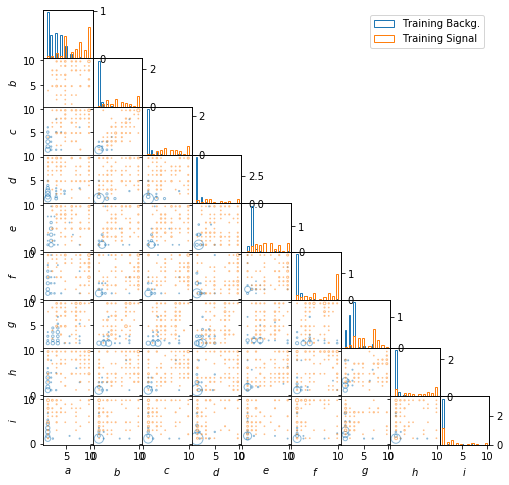

In [27]:
nd3 = 9
drawsamples(train3_bg[:,:nd3], 'Training Backg.', 
            train3_sg[:,:nd3], 'Training Signal', 
            legend=True,names=True,fig_kw=dict(figsize=(8,8)),
            scat_kw=dict(scale=.001,alpha=.1,facecolor='none'),
            color='auto')

Immediately we see that the background sample (those with benign tumors) generally have very low scores in each of the variables - most often zero in fact.  This gives some hope, but can also prove difficult if the distributions are too evenly distributed. 

#### Training sample 

We do the PCA on the training sample. 

In [28]:
bgcut3    = .20
sgcut3    = .1
pca3_bg, pca3_sg, edual3 = run_pca(train3_bg,train3_sg,3,bgcut3,sgcut3)

We see, as noted above, that the background sample is characterised by low scores, and thus very low distance to the background principal space $\mathbb{P}_{\mathrm{background}}$.  However, we also see that the signal (those with malignant tumors) have scores that are widely distributed over both the background and signal spaces.  What is even more worrying, is that the background sample is somewhat evenly distributed over the signal space $\mathbb{P}_{\mathrm{signal}}$. 

Thus we end up with $6\%$ false positives.  That is, in $6\%$ of the time we would say we have a malignant tumor it was in fact benign.  On the other hand, we have $8\%$ false negatives, meaning we should, from a treatment perspective only consider the cases of malignant tumors (positives), since only diagnosis of malignant tumors spurs intervention in the form of treatment (chemotherapy, surgery, and so on). 

#### Undiagnosed sample

Let us apply this to some data where we do not know the diagnosis.  Thus, we have a data set like the above, but with the last column missing 

In [29]:
data3t = np.genfromtxt('breast-cancer-wisconsin_mod_real.txt')
ukn    = data3t[:,1:]

We first plot the data

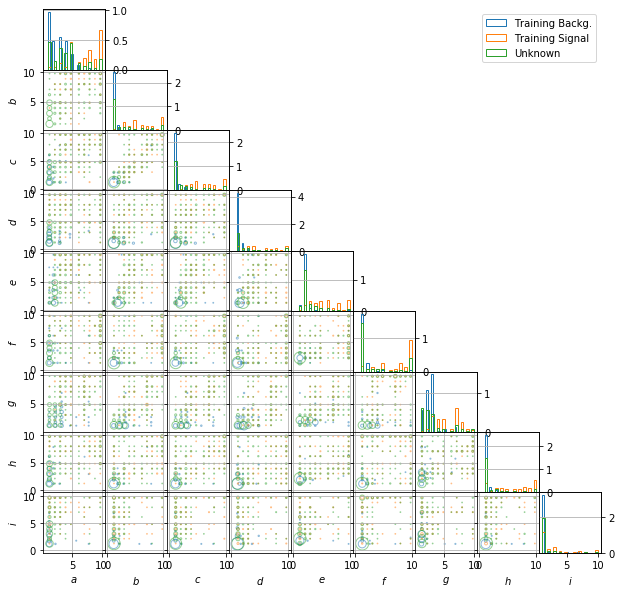

In [30]:
drawsamples(train3_bg[:,:nd3], 'Training Backg.', 
            train3_sg[:,:nd3], 'Training Signal', 
            ukn[:,:nd3],       'Unknown',  
            legend=True,names=True,fig_kw=dict(figsize=(10,10)),
            scat_kw=dict(scale=.001,alpha=.1,facecolor='none'),
            color='auto')

Off hand, the sample looks very much like our training samples.  Let us know calculate the distance of each sample to both the background and signal space and plot those distributions 

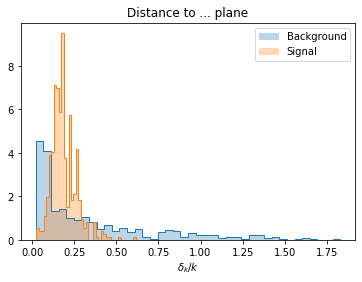

In [31]:
bge3t  = pca3_bg.test(ukn,9-3)
sge3t  = pca3_sg.test(ukn,9-3)
drawerr(bge3t,sge3t,None,bins=40,
        title='Distance to ... plane')

To find the patients with a possible malignant tumor, we apply the cuts $0.1,0.2$ for background and signal respectively.  First, we find the row numbers corresponding to these two cuts.

In [32]:
mix = np.where(sge3t/sgcut3<bge3t/bgcut3)[0]
bix = np.where(bge3t/bgcut3<sge3t/sgcut3)[0]

Then we extract the patient IDs corresponding to these rows and for the sake of diagnostics print out how many we found in each group. 

In [33]:
mid = data3t[mix,0]
bid = data3t[bix,0]
print(len(mix),len(bix),len(data3t))

172 311 483


What we find is 172 and 311 out of 483 patients supposedly have malignant or benign tumors, respectively.  

We can now plot the distance of each of these to the signal and background spaces. 

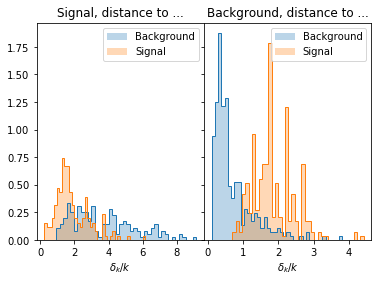

In [34]:
fig, ax = plt.subplots(ncols=2,sharey=True,
                      gridspec_kw=dict(wspace=0))
drawerr(bge3t[mix]/bgcut3,sge3t[mix]/sgcut3,None,ax=ax[0],bins=40,
        title='Signal, distance to ...')
drawerr(bge3t[bix]/bgcut3,sge3t[bix]/sgcut3,None,ax=ax[1],bins=40,
        title='Background, distance to ...')

#### Check 

In fact, we do know which of the patients above had a malignant tumor and which had a benign.  We read in that data. 

In [35]:
sg3d     = np.genfromtxt('malignant_true.txt')
bg3d     = np.genfromtxt('benign_true.txt')
sg3t     = sg3d[:,1:10]
bg3t     = bg3d[:,1:10]

Again, we plot the data to get an idea of what it all looks like. 

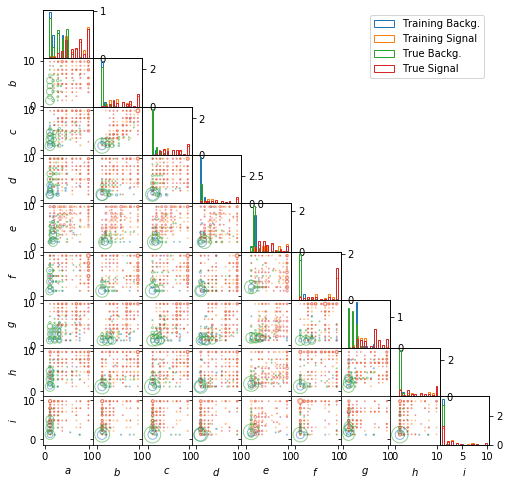

In [36]:
drawsamples(train3_bg[:,:nd3], 'Training Backg.', 
            train3_sg[:,:nd3], 'Training Signal', 
            bg3t[:,:nd3],      'True Backg.',  
            sg3t[:,:nd3],      'True Signal',
            legend=True,names=True,fig_kw=dict(figsize=(8,8)),
            scat_kw=dict(scale=.001,alpha=.1,facecolor='none'),
            color='auto')

Just because we can, we do a PCA with our training samples above. 

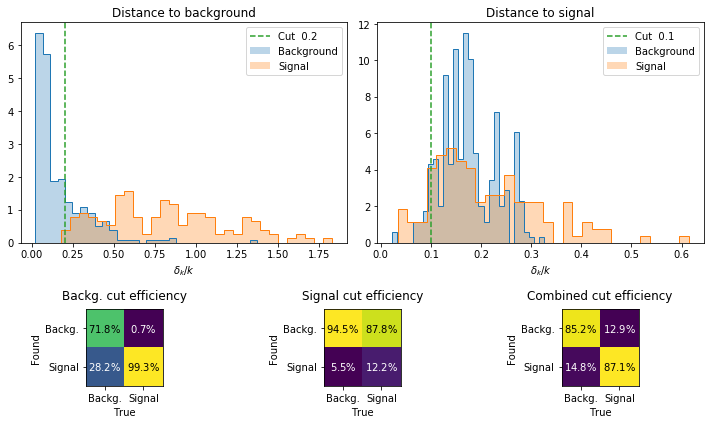

In [37]:
_,_,edual3t = run_pca(bg3t,sg3t,3,bgcut3,sgcut3,'',pca3_bg,pca3_sg);

From this, we see that we have 

- $87.1\%$ true positives 
- $14.8\%$ false positives 

which is much worse than our training sample.  Clearly, the training sample isn't as representative as we would like, resulting in over-treatment of some patients.  

Our negatives fall into 

- $85.2\%$ true negatives 
- $12.9\%$ false negatives 

Thus, some patients may have an undiagnosed malignant tumor, and thus not be treated. 

Since we have the patient IDs of our patients, we can compare these to those that do have a malignant or benign tumor.  

In [38]:
midt = sg3d[:,0]
bidt = bg3d[:,0]

for (found,ref), dia in zip(((mid,midt), (bid,bidt)),('postives','negatives')):
    nt = sum([i in ref for i in found])
    nf = sum([i not in ref for i in found])
    nr = len(ref)
    rt = nt / nr * 100
    rf = nf / nr * 100
    print(f'{nt:3d} out of {nr:3d} = {rt:4.1f}% true  {dia}\n'
          f'{nf:3d} out of {nr:3d} = {rf:4.1f}% false {dia}')

121 out of 139 = 87.1% true  postives
 51 out of 139 = 36.7% false postives
293 out of 344 = 85.2% true  negatives
 18 out of 344 =  5.2% false negatives


Which means I get $100\%$ credit - hip hip hurray!

## AdaBoost 

A popular machine learning algorithm is [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) - or Adaptive Boosting.  As the name implies it is a _boosting_ algorithm where some features are boosted on each iteration.  

Here, we will use the implementation from [scikit-learn](https://scikit-learn.org/).  If the package `sklearn` isn't available it can be installed by one of

    pip3 install scikit-learn 
    apt install python3-sklearn  # Debian and derivatives

### 3 Variables 

Here, we will repeat the analysis we did above, but using an _AdaBoost_ machine-learning algorithm. 

In [39]:
def run_ada(bg,sg,ada=None,epca=None,bins=30,**kwargs):
    from matplotlib.pyplot import subplots,tight_layout,hist,legend
    from numpy import concatenate,zeros,ones,flip,newaxis
    
    try:
        from sklearn.ensemble import AdaBoostClassifier
        from sklearn.metrics  import confusion_matrix 
    except:
        print('sklearn not available')
        return None
    
    x = concatenate((bg,sg))
    y = concatenate((zeros(len(bg)),ones(len(sg))))
    
    if ada is None:
        ada = AdaBoostClassifier(**kwargs)

        ada.fit(x,y)
        
        d = ada.decision_function(x)
        hist(d[y==0],bins,histtype='step',label='Background')
        hist(d[y==1],bins,histtype='step',label='Signal')
        legend()
        
    else:
        p = ada.predict(x)
        c = confusion_matrix(y,p)
        c = flip(c.astype('float')/c.sum(axis=1)[:,newaxis])
        
        neff = 1 if epca is None else 2
        fig, ax = subplots(ncols=neff,squeeze=False)
        draweff(c,'From AdaBoost',ax=ax[0,0])
        if epca is not None:
            draweff(epca,'From PCA',ax=ax[0,1])

        tight_layout()
        
    return ada 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

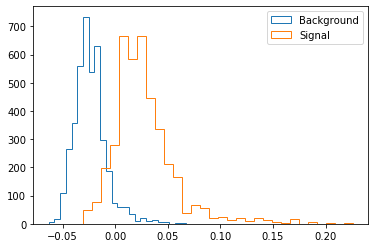

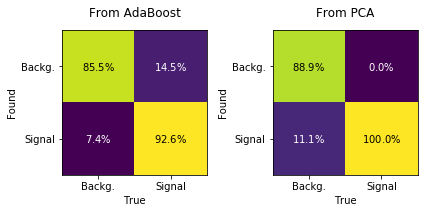

In [40]:
ada1 = run_ada(train1_bg,train1_sg)
run_ada(test1_bg,test1_sg,ada1,edual1t)

As we see, our simple PCA algorithm does as well, if not better than the more complicated _AdaBoost_. 

### 16 variables. 

Again, we repeat the exercise from above 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

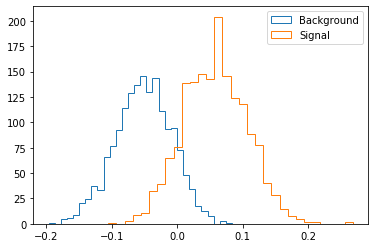

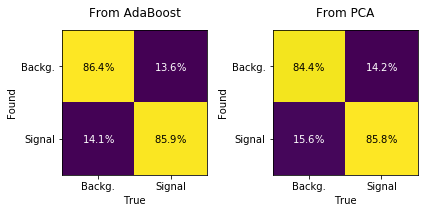

In [41]:
ada2 = run_ada(train2_bg,train2_sg)
run_ada(test2_bg,test2_sg,ada2,edual2t)

Here, _AdaBoost_ is doing slightly better than the PCA

### Breast cancer markers 

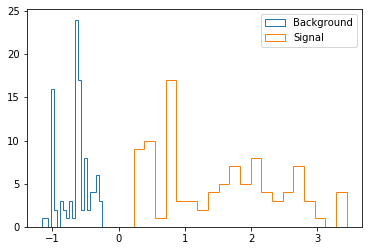

In [42]:
ada3 = run_ada(train3_bg,train3_sg,bins=20)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

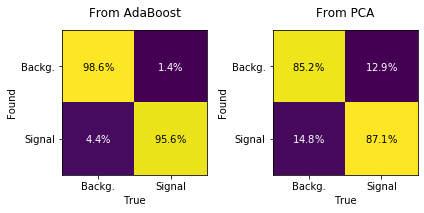

In [43]:
run_ada(bg3t,sg3t,ada3,edual3t)

Here, we do see an improvement of _AdaBoost_ over the simple PCA.  The reason for this is obvious is we look at the original data again 

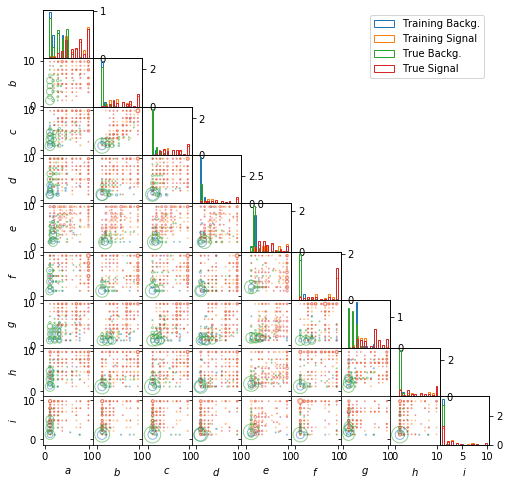

In [44]:
drawsamples(train3_bg[:,:nd3], 'Training Backg.', 
            train3_sg[:,:nd3], 'Training Signal', 
            bg3t[:,:nd3],      'True Backg.',  
            sg3t[:,:nd3],      'True Signal',
            legend=True,names=True,fig_kw=dict(figsize=(8,8)),
            scat_kw=dict(scale=.001,alpha=.1,facecolor='none'),
            color='auto')

_Most_ of the background (benign tumors) variables cluster around 0 - take for example variables $c$ and $d$ above

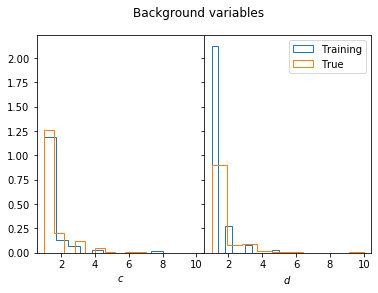

In [45]:
fig, ax = plt.subplots(ncols=2,sharex=True,sharey=True,
                       gridspec_kw=dict(wspace=0))
fig.suptitle('Background variables')
for i,a in zip((2,3),ax):
    opts=dict(density=True,histtype='step')
    a.hist(train3_bg[:,i],10,**opts,label='Training')
    a.hist(bg3t[:,i],     10,**opts,label="True")
    a.set_xlabel(fr'${chr(ord("a")+i)}$')
ax[1].legend();

_AdaBoost_ is particularly well suited to isolate these, which is also evident from the decision function plotted above. 